## Ranking of estimation methods for a given dataset 

We illustrate the comparison of various estimation methods for a given datasets by ranking them according to their performance against refutation tests accounting for both the observed unmodelled confounding error and unobserved confounding error. 

In [1]:
# Importing all the required libraries
import sys
import argparse
import xgboost
import numpy as np
import pandas as pd
import os
import pdb
import random
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import mean_absolute_error
from dowhy import CausalModel
from datetime import datetime
from collections import namedtuple

import statsmodels.api as sm
from sklearn import linear_model

import dowhy
from dowhy.utils import dgp
from dowhy.utils.dgps.linear_dgp import LinearDataGeneratingProcess
from dowhy import CausalModel
from datetime import datetime
from collections import namedtuple
from dowhy.causal_refuters.add_unobserved_common_cause import AddUnobservedCommonCause

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms


In [2]:
def convert_singleton_to_float(arr):
    '''Helper function.'''
    array = []

    if len(arr) == 1 and type(arr[0]) != np.ndarray:
        return arr[0]

    for element in arr:
        while type(element) == np.ndarray or isinstance(element, list) :
            if len(element) > 1:
                raise ValueError("This script only accepts one value for the refute")
            element = element[0]
        array.append(element)

    return array

In [3]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

RESULTSFOLDER = "results/"
ensure_dir(RESULTSFOLDER)
# Create the estimator named tuple to wrap the name and properties
Estimator = namedtuple('Estimator', ['name','params'])
Refuter = namedtuple('Refuter', ['name','params'])

class Experiment():
    '''
    Class to define the experiment setup to compare a list of estimators across a list of refuters for the given dataset. 
    '''
    def __init__(self, **kwargs):
        self.experiment_name = kwargs['experiment_name']
        self.experiment_id = kwargs['experiment_id']
        self.num_experiments = kwargs['num_experiments']
        self.sample_sizes = kwargs['sample_sizes']
        self.dgps = kwargs['dgps']
        self.estimators = kwargs['estimators']
        self.refuters = kwargs['refuters']
        self.results = []
        self.simulate_unobserved_confounding = kwargs["simulate_unobserved_confounding"]

        # Handle input errors in sample_sizes
        if isinstance(self.sample_sizes, list) == False:
            if type(self.sample_sizes) != int:
                raise ValueError('The input to "sample_sizes" should be an int or a list')
            else:
                self.sample_sizes = [self.sample_sizes]

        # Handle input errors in DGPs
        if isinstance(self.dgps, list) == False:
            if isinstance(self.dgps, DataGeneratingProcess) == False:
                raise ValueError('The input to "dgps" should be a list or a subclass of "DataGeneratingProcess"')
            else:
                self.dgps = [self.dgps]

        # Handle inputs errors in estimators
        if isinstance(self.estimators, list) == False:
            if isinstance(self.estimators, Estimator) == False:
                raise ValueError('The input to "estimators" should be a list or an Estimator namedtuple')
            else:
                self.estimators = [self.estimators]

        # Handle input errors in refuters
        if isinstance(self.refuters, list) == False:
            if isinstance(self.refuters, Refuter) == False:
                raise ValueError('The input to "refuters" should be a list of a Refuter namedtuple')
            else:
                self.refuters = [self.refuters]

    def experiment(self):
        print("\n\nRunning Experiment:",self.experiment_name + '_' + str(self.experiment_id) )

        for exp in range(self.num_experiments):
            print("\n\nRunning Experiment Number:",exp)

            for sample_size in self.sample_sizes:

                print("\n\nCurrent Sample Size:",sample_size)

                for dgp in self.dgps:
                    print("\n\nThe current DGP:")
                    print(dgp)
                    estimates = []
                    estimate_values = []
                    estimated_effect = []
                    new_effect = []
                    p_value = []
                    data = dgp.generate_data(sample_size)
                    print("printing data shape")
                    print(data.values.shape)
                    print(dgp.true_value)
                    print("check")
                    if dgp.treatment_is_binary:
                        data[dgp.treatment] = data[dgp.treatment].astype(bool)
                    #k = len(dgp.confounder)-4
                    #confounder_list = random.sample(dgp.confounder, k)
                    confounder_list = ['w2','w3']

                    
                    s = set(confounder_list)
                    unobserved_confounders = [x for x in dgp.confounder if x not in s]
                    df_unobserved_confounders = pd.DataFrame(data = data[[c for c in data.columns if c in unobserved_confounders]])

                    df_unobserved_confounders.to_csv("results/unobserved_confounders.csv")
                    print("printing length of confounder list:", len(confounder_list))
                    print("printing confounder list:", confounder_list)

                    

                    print("data columns")
                    
                    print("data columns", data.columns)
                    model = CausalModel(
                        data = data,
                        treatment = dgp.treatment,
                        outcome = dgp.outcome,
                        common_causes = confounder_list,
                        effect_modifiers = dgp.effect_modifier
                    )

                    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
                    
                    print("identified_estimand:", identified_estimand)
                    #print("identified_estimand:", identified_estimand)
                    print("\n\nRunning the estimators:\n")
                    for estimator in self.estimators:
                        print("The current estimator:", estimator)
                        print("estimator.params", estimator.params)
                        estimate = model.estimate_effect(
                            identified_estimand,
                            method_name = estimator.name,
                            method_params = estimator.params
                        )
                        print("printing estimate's type")
                        print(type(estimate))
                        estimates.append(estimate)
                        estimate_values.append(estimate.value)
                    estimate_values = convert_singleton_to_float(estimate_values)
                    print("estimate_values", estimate_values)
                    print("\n\nRunning the refuters:\n")
                    for refuter in self.refuters:
                        print("The current refuter:", refuter)
                        
                        for estimate in estimates:
                            if self.simulate_unobserved_confounding == True:
                                print("********%%%%%%%%%$$$$$&&^**^^^^*^*^*")
                                if refuter.name == 'dummy_outcome_refuter':
                                    add_unobserved_confounder = AddUnobservedCommonCause(data, identified_estimand, estimate)
                                    print("add_unobserved_confounder", add_unobserved_confounder)
                                    unobserved_confounder_values = add_unobserved_confounder.include_simulated_confounder(convergence_threshold = 0.11, c_star_max = 1500)
                                    refuter.params['unobserved_confounder_values'] = unobserved_confounder_values
                                    print('refuter.params', refuter.params)
                            refute = model.refute_estimate(
                                identified_estimand,
                                estimate,
                                method_name = refuter.name,
                                **refuter.params,
    
                                

                            )
                            print("printing refute's type")
                            print(type(refute))
                            if(refuter.name == 'dummy_outcome_refuter'):
                                refute = refute[0]
                            if refute.refutation_result is not None:
                                p_value.append(refute.refutation_result['p_value'])
                            else:
                                p_value.append(None) 

                            estimated_effect.append(refute.estimated_effect)
                            #print("refute.estimate_effect()", refute.estimate_effect())
                            new_effect.append(refute.new_effect)

                    estimated_effect = convert_singleton_to_float(estimated_effect)
                    new_effect = convert_singleton_to_float(new_effect)
                    p_value = convert_singleton_to_float(p_value)
                    true_value = convert_singleton_to_float(dgp.true_value)
                    
                    print("estimated effect", estimated_effect)
                    print("new_effect", new_effect)
                    print("p_value", p_value)
                    print("true value", true_value)
                    self.results.append([exp, sample_size, dgp.NAME, *estimate_values, *estimated_effect, *new_effect, *p_value, true_value])


        print("\n\nCompleted all experiments. Saving the data...")

        COLUMNS = ['EXPERIMENT', 'SAMPLE_SIZE', 'DGP']
        RESULT_CATEGORIES = ['ESTIMATED_EFFECT', 'NEW_EFFECT', 'P_VALUE']
        estimator_names = [estimator.name for estimator in self.estimators]
        refuter_names = [refuter.name for refuter in self.refuters]

        for estimator_name in estimator_names:
            COLUMNS += ['ORIGINAL_ESTIMATE'+ ':' + estimator_name]

        for result_category in RESULT_CATEGORIES:
            for refuter_name in refuter_names:
                for estimator_name in estimator_names:
                    COLUMNS += [refuter_name + ':' + estimator_name + ':' + result_category]

        COLUMNS += ['TRUE_VALUE']

        csv_file = RESULTSFOLDER + self.experiment_name+ '_' + str(self.experiment_id) + '_' + str(datetime.utcnow().date()) + '_data.csv'
        onlyres_csv_file = RESULTSFOLDER + "onlyres_"+ self.experiment_name+ '_' + str(self.experiment_id) + '_' + str(datetime.utcnow()) + '_data.csv'
        self.results = pd.DataFrame(data=self.results,columns=COLUMNS)
        self.results.to_csv(csv_file.replace(" ", ""), index=False)

        print("Data has been saved in ",csv_file)

        return csv_file

In [4]:
#Defining the Data Generating Process 
ldgp = LinearDataGeneratingProcess(treatment=['t1'], outcome=['y'], confounder=['w1','w2', 'w3','w4','w5','w6'], effect_modifier=['x1','x2'], seed=None, treatment_is_binary=True)

#Defining the sample size 
sample_size = 1000

dgp_dict = {'ldgp':ldgp}
dgp_list = []
dgp_list.append( dgp_dict['ldgp'] )


# Create a namedtuple to store the name of the estimator and the parameters passed
estimator_list = ["backdoor.linear_regression",
                  #"backdoor.propensity_score_stratification",
                  "backdoor.propensity_score_matching",
                  "backdoor.propensity_score_weighting",
                  "backdoor.econml.dml.DML",
                  "backdoor.econml.drlearner.LinearDRLearner",
                  #"backdoor.econml.metalearners.TLearner",
                  #"backdoor.econml.metalearners.XLearner",
                  #"backdoor.causalml.inference.meta.LRSRegressor",
                  #"backdoor.causalml.inference.meta.XGBTRegressor",
                  #"backdoor.causalml.inference.meta.MLPTRegressor",
                  #"backdoor.causalml.inference.meta.BaseXRegressor"
                ]
method_params= [    None,
                    #None,
                    { "init_params":{} },
                    { "init_params":{} },
                    {"init_params":{'model_y':GradientBoostingRegressor(),
                                    'model_t': GradientBoostingRegressor(),
                                    "model_final":LassoCV(),
                                    'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                     "fit_params":{}},
                    {"init_params":{ 'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto'),
                        },
                    "fit_params":{}
                    },
                    '''{"init_params": {'models': GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(sample_size/100))
                                    },
                    "fit_params":{}
                    },
                    {"init_params":{'models': GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(sample_size/100)),
                        'propensity_model': RandomForestClassifier(n_estimators=100, max_depth=6,
                                                                              min_samples_leaf=int(sample_size/100))
                        },
                     "fit_params":{}
                    },
                    {"init_params":{},},
                    {"init_params":{
                        'learner':XGBRegressor()
                        }
                    }'''
                ]
estimator_tuples = []
refuter_tuples = []

refuter_list = ['dummy_outcome_refuter']
refuter_params = [{'num_simulations':5,'transformation_list': [('random_forest',{'n_estimators':100, 'max_depth':6})], 'true_causal_effect':(lambda x:0.5)}]


# Iterate through the names and parameters to create a list of namedtuples
for name, param in zip(estimator_list,method_params):
    estimator_tuples.append(Estimator._make([name, param]))
    
for name, param in zip(refuter_list, refuter_params):
    refuter_tuples.append(Refuter._make([name, param]))


In [5]:
def plot_MAEs(res):
    true_value_column = res.columns[-1]
    estimate_columns=res.columns[3:-1]
    #print(estimate_columns)
    #print(type(estimate_columns))
    estimate_columns.append(pd.Index(res["TRUE_VALUE"]))
    #print(estimate_columns)
    fig, ax = plt.subplots()
    MAE ={}
    for colname in estimate_columns:
        if colname not in ('ORIGINAL_ESTIMATE:backdoor.propensity_score_weighting',):
                           #'ORIGINAL_ESTIMATE:backdoor.econml.metalearners.TLearner'):
            plt.plot(res[colname], res["TRUE_VALUE"], marker='o', linestyle="None", label=colname)
            "Mean Absolute Error (MAE): {}".format(mean_absolute_error(res[colname], res["TRUE_VALUE"]))
            MAE[colname] = mean_absolute_error(res[colname], res["TRUE_VALUE"])
    fig.suptitle('Calibration plot showing the accuracy of different causal estimators [P(T=1)=0.9]')
    ax.set_xlabel('Estimated effect')
    ax.set_ylabel('True causal effect')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),
              fancybox=True, shadow=True, ncol=2)
    plt.show()
    print("Printing MAE of various estimates: ")
    MAE_values = {k: v for k, v in sorted(MAE.items(), key=lambda item: item[1], reverse = True)}
    for k,v in MAE_values.items():
        print(k, v)

In [6]:
def plot_estimators_and_refuters(refuter, estimator):   
    x = list(res['EXPERIMENT'])
    y1 = list(res[refuter+':'+estimator+':ESTIMATED_EFFECT'])
    y2 = list(res[refuter+':'+estimator+':NEW_EFFECT'])
    #print(res['TRUE_VALUE'])
    y3 = list(res['TRUE_VALUE'])
    y4 = list(res[refuter+':'+estimator+':P_VALUE'])
    plt.scatter(x, y1, c ="blue", label = "Estimated Effect") 
    plt.scatter(x, y2, c ="red", label = "New Effect")
    plt.scatter(x, y3, c ="green", label = "True Value")
    plt.scatter(x, y4, c ="yellow", label = "P Value")
    plt.xlabel("EXPERIMENT") 
    plt.ylabel("EFFECT")
    legend = plt.legend(loc=4, fontsize='small', fancybox=True)
    plt.title(estimator) 
    plt.show()
    plt.savefig(estimator+'.png')

In [7]:
def plot_deviations(estimator_list, deviation_list):
    plt.scatter(estimator_list, deviation_list)
    plt.xticks(estimator_list, estimator_list, rotation='vertical')
    plt.show()

## Observed unmodelled confounding error

For each estimator, we use dummy outcome refuter to check the observed unmodelled confounding error for each estimator. That is, we run the refutation test for each estimator only on the observed confounders and analyse what amount of confounding error is present unmodelled amongst the observed variables.

In [8]:
# Define the properties of the experiment
# The name of the experiment
# The experiment ID
# The number of experiments to be run with the SAME parameters
# The size of the samples to be run
# The list of DGPs to be run
# The list of estimators
observed_confounding_error = Experiment(
    experiment_name='Test',
    experiment_id='1',
    num_experiments=10, # 10
    sample_sizes=sample_size,
    dgps=dgp_list,
    estimators=estimator_tuples,
    refuters=refuter_tuples,
    simulate_unobserved_confounding = False 
)

# Run the experiment
res = pd.read_csv(observed_confounding_error.experiment())

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['t1'] on outcome ['y']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]




Running Experiment: Test_1


Running Experiment Number: 0


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {}
        bias: {}
        seed: None
        treatment_is_binary: True
        percentile: 0.9
        
printing data shape
(1000, 10)
[0.14357732]
check
printing length of confounder list: 2
printing confounder list: ['w2', 'w3']
data columns
data columns Index(['x1', 'x2', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 't1', 'y'], dtype='object')
identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3

INFO:dowhy.causal_estimator:b: y~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}}


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [59.281507967308805, 62.418708593442695, 59.41598709654056, 45.67013170357128, 60.984396846818875]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>})


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.cau

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:d

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [1.5104993248915284, -2.4799959590778, -1.2642404127398776, 0.2803962872779986, 0.07914706314014612]
p_value [0.21501559916000046, 0.24859005577691917, 0.28206259071833095, 0.38817158296233123, 0.4253393941752771]
true value 0.1435773162705152


Running Experiment Number: 1


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.5400532 ],
       [  0.93615463],
       [  0.60358939],
       [  1.47769705],
       [ -1.58058638],
       [ -0.41425403]]), 'confounder=>outcome': array([[100.67531551],
       [  0.25482963],
       [  1.08417606],
       [ -1.71312064],
       [  1.18949543],
       [  2.13293067]]), 'effect_m

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [60.77935464481793, 60.8839300994152, 60.85406801354386, 55.66950014532471, 61.100768037310345]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>})


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.cau

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:d

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-2.4745530139868324, 0.39007344504342745, 1.7057218688271072, 0.19317789196700788, -2.4366625339892254]
p_value [0.217112102742277, 0.4879151090432915, 0.1836554763863374, 0.21355581732312556, 0.006732276894335754]
true value 0.449205464249595


Running Experiment Number: 2


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.28276226],
       [  1.28803946],
       [  0.45448878],
       [  0.88215811],
       [  1.13237151],
       [ -2.91101921]]), 'confounder=>outcome': array([[99.90266926],
       [-1.86802468],
       [ 1.57984168],
       [ 0.87668243],
       [ 2.06269101],
       [ 0.85546169]]), 'effect_modifi

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2



<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [72.85058217295, 80.50911773504451, 72.74528438767814, 76.47320141382123, 72.1119293553635]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>})


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.cau

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:d

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [0.43811190164533054, 2.1712179181740945, 2.302718564265935, -0.08152204894251865, -0.44616894351388214]
p_value [0.48641712532412784, 0.3566563654472135, 0.30797783844330645, 0.3157460634739604, 0.10448059058974923]
true value -0.49785393681358786


Running Experiment Number: 3


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 1.00591399e+02],
       [-1.08380637e+00],
       [-4.01560500e-01],
       [-1.15845280e+00],
       [-7.73616095e-01],
       [ 9.93766450e-02]]), 'confounder=>outcome': array([[100.1549028 ],
       [  0.31272476],
       [  0.61218722],
       [ -0.6274065 ],
       [  0.93148437],
       [ -1

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [60.02975557892618, 56.948298789802415, 59.77390172578493, 51.12301004634185, 59.96223364554626]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>})


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.cau

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:d

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [0.3725939257344271, -2.1189984469477365, -0.2753599571826608, 0.2986664703263532, -2.6245647676522905]
p_value [0.47729639555237435, 0.024529412401198658, 0.38342717914861935, 0.45991967792971833, 0.0002423425428386139]
true value -0.7340155943284433


Running Experiment Number: 4


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[99.7679695 ],
       [-0.20963829],
       [-0.53930106],
       [ 0.13745454],
       [ 1.04403051],
       [-0.82112326]]), 'confounder=>outcome': array([[99.23507172],
       [ 0.12458274],
       [-0.80990303],
       [ 1.11090119],
       [ 1.3998517 ],
       [ 0.94017972]]), 'effect_modif

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [64.42001280104063, 61.05187479851604, 64.02595566790932, 68.11042150940423, 64.55237247215436]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>})


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.cau

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:d

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-3.3951259193243204, -4.780568149121785, -1.600310340214234, -0.7907050094638091, -2.5874940538970455]
p_value [0.059426968246072964, 0.016478883767357844, 0.06922504219915626, 0.09333753036726, 0.0968968371151997]
true value -1.8472279130279248


Running Experiment Number: 5


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[98.81973439],
       [ 3.04992377],
       [ 0.31479874],
       [-1.74434293],
       [-1.5828148 ],
       [ 0.15890835]]), 'confounder=>outcome': array([[100.71780153],
       [  0.5444118 ],
       [ -0.45438131],
       [ -0.19288047],
       [ -0.30670869],
       [  0.40070554]]), 'effect_modi

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [50.817883093456906, 51.89057310692511, 52.14305486261107, 34.84183062565673, 50.11765274530727]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>})


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.cau

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:d

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [3.257218299101061, 1.951663788495911, 0.35056071516334175, 0.6720649317161044, 1.8737660391007451]
p_value [0.11516476702615308, 0.22888199517050106, 0.4611845157031842, 0.46267759001031306, 0.35425385117079256]
true value -0.30993010150527006


Running Experiment Number: 6


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.7960951 ],
       [ -0.90396573],
       [  1.1513372 ],
       [ -0.19771394],
       [ -0.11397792],
       [ -0.56742083]]), 'confounder=>outcome': array([[ 1.01401779e+02],
       [-7.78002143e-02],
       [-1.85350135e+00],
       [-5.24606409e-01],
       [ 8.54072343e-01],
       [ 4.6693445

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [60.6990199965188, 50.565428203866404, 58.555306922805606, 47.739909908282456, 61.146536898318764]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>})


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.cau

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:d

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [1.2878766427776736, 0.046501330220839555, 0.9040018615197614, -0.23959254163621221, 1.0724025532318024]
p_value [0.38685649001424544, 0.44083420016346675, 0.4625072778849648, 0.3191576777243932, 0.07642849884087856]
true value -0.22228817972977924


Running Experiment Number: 7


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 9.98802014e+01],
       [ 7.29822280e-01],
       [-1.84363071e+00],
       [-9.09616206e-01],
       [ 5.42622433e-02],
       [ 3.93696572e-01]]), 'confounder=>outcome': array([[98.85150586],
       [ 0.43908178],
       [ 0.90515854],
       [-0.54453427],
       [-0.46042737],
       [-1.22942

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [73.75251322103617, 72.13029569590095, 73.91048259869228, 65.0276882113894, 73.80015679019813]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>})


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.cau

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:d

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [1.8059302787821825, 0.07889924607886659, -1.4660226969314523, 1.2076251146231978, -0.7549321754657182]
p_value [0.326236543364673, 0.45669399885428297, 0.3061389873539744, 0.33503542821396215, 0.3994718355119159]
true value 0.8280166745666404


Running Experiment Number: 8


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[99.70643807],
       [-0.94166663],
       [ 1.09699465],
       [-1.22221714],
       [-0.49325578],
       [-1.08064337]]), 'confounder=>outcome': array([[101.56016925],
       [  1.09859304],
       [  0.52706775],
       [  0.40143497],
       [ -1.06768257],
       [ -0.9257862 ]]), 'effect_modifie

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [69.31884362705838, 87.30492836116676, 70.66659474790418, 60.635178407014905, 69.36818435528575]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>})


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.cau

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:d

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-0.6781422706805879, 0.07077949092545097, 0.6565611212442795, -1.8591509663176846, 0.29687110271841155]
p_value [0.373460052192658, 0.45761222359359954, 0.47549528459000934, 0.15210825228852132, 0.4685882603672733]
true value -1.9478766747356708


Running Experiment Number: 9


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[99.57305315],
       [ 0.6984461 ],
       [-1.20053665],
       [ 0.36031133],
       [-1.09354532],
       [ 0.2262613 ]]), 'confounder=>outcome': array([[100.22419895],
       [  0.66506428],
       [ -0.98811932],
       [ -0.3378872 ],
       [ -0.88137592],
       [  0.43839822]]), 'effect_modi

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [59.333218387419585, 58.646413218404, 60.97742159851749, 49.916369527957244, 58.5155614140518]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>})


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.cau

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:d

printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [1.496453509225897, -0.2668333406568644, 1.0511224541576076, -1.798588035552989, 0.0023916986901009185]
p_value [0.30374155022920946, 0.3642770563191525, 0.3953569836940987, 0.09113969859819848, 0.4489495194010843]
true value -0.31087694276013117


Completed all experiments. Saving the data...
Data has been saved in  results/Test_1_2021-01-27_data.csv


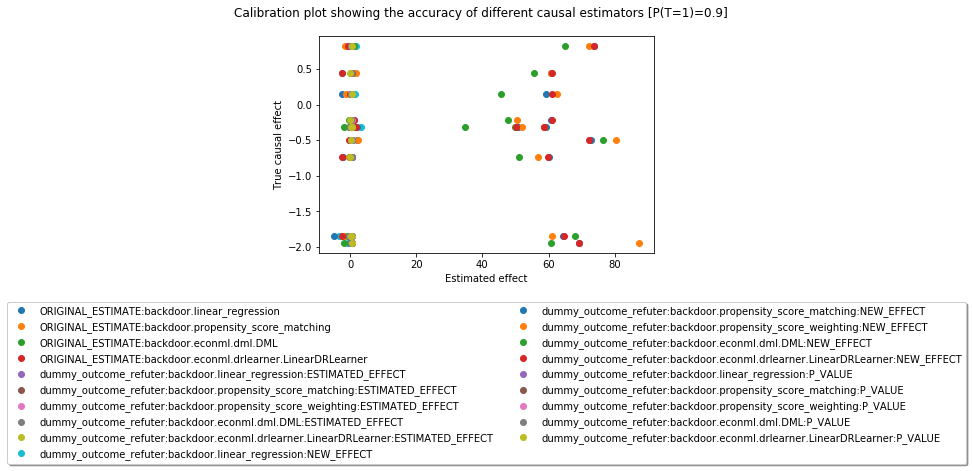

Printing MAE of various estimates: 
ORIGINAL_ESTIMATE:backdoor.propensity_score_matching 64.6798838490298
ORIGINAL_ESTIMATE:backdoor.econml.drlearner.LinearDRLearner 63.61090624481692
ORIGINAL_ESTIMATE:backdoor.linear_regression 63.57319613783475
ORIGINAL_ESTIMATE:backdoor.econml.dml.DML 55.96565113865781
dummy_outcome_refuter:backdoor.linear_regression:NEW_EFFECT 1.7013445535046063
dummy_outcome_refuter:backdoor.propensity_score_matching:NEW_EFFECT 1.5012300834459282
dummy_outcome_refuter:backdoor.propensity_score_weighting:NEW_EFFECT 1.4217737266940838
dummy_outcome_refuter:backdoor.econml.drlearner.LinearDRLearner:NEW_EFFECT 1.3252150701366132
dummy_outcome_refuter:backdoor.linear_regression:ESTIMATED_EFFECT 1.0105303236947338
dummy_outcome_refuter:backdoor.propensity_score_matching:ESTIMATED_EFFECT 1.0105303236947338
dummy_outcome_refuter:backdoor.propensity_score_weighting:ESTIMATED_EFFECT 1.0105303236947338
dummy_outcome_refuter:backdoor.econml.dml.DML:ESTIMATED_EFFECT 1.01053032

In [9]:
#PLOT
#This plot shows the Mean Absolute Error of the Orginal Estimate from the true value and of the New Effect from 
#the expected value for each estimator. 
plot_MAEs(res)

### Ranking based on Original Estimate

The Original Estimate is calculated in the presence of the True Value (that is, the ground truth). However in many real life datasets, the ground truth may not be known. Hence, we want the ranking produced by our refutation tests to be in coherence with that obtained from the Original Estimates. According to the Original Estimate values, the ranking of the estimators should be as follows (the method with the least MAE should get the best rank):
1. DMLCateEstimator 
2. LinearRegression 
3. LinearDRLearner 
4. Propensity Score Matching 

In [10]:
estimator_list = ["backdoor.linear_regression",
                  #"backdoor.propensity_score_stratification",
                  "backdoor.propensity_score_matching",
                  "backdoor.econml.dml.DML",
                  "backdoor.econml.drlearner.LinearDRLearner",
                  #"backdoor.econml.metalearners.TLearner",
                  #"backdoor.econml.metalearners.XLearner",
                  #"backdoor.causalml.inference.meta.LRSRegressor",
                  #"backdoor.causalml.inference.meta.XGBTRegressor",
                  #"backdoor.causalml.inference.meta.MLPTRegressor",
                  #"backdoor.causalml.inference.meta.BaseXRegressor"
                ]

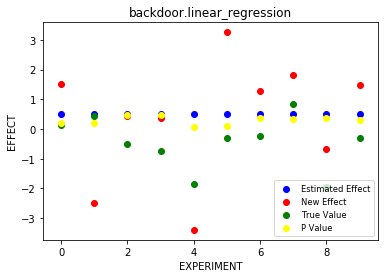

3.620862678166359


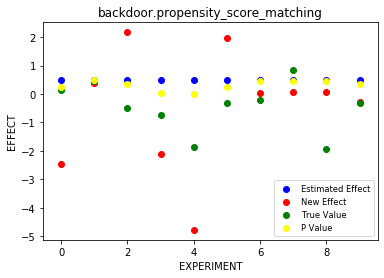

-4.937260676865596


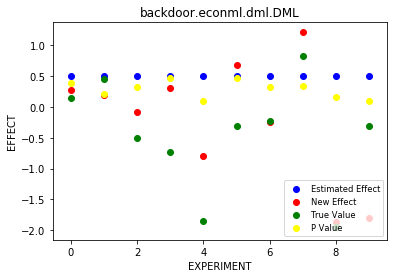

-2.117627906002552


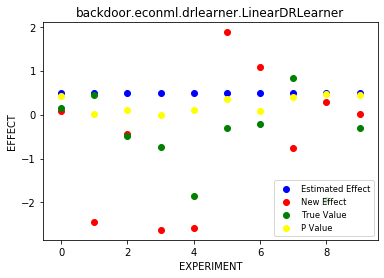

-5.525244017636955


<Figure size 432x288 with 0 Axes>

In [11]:
#This plot shows the deviation of the original estimate, the new effect and the estimated effect from the true value 
refuter = 'dummy_outcome_refuter'
deviation_list = []
for estimator in estimator_list:
    plot_estimators_and_refuters(refuter, estimator)
    avg_deviation = ((res[refuter+':'+estimator+':NEW_EFFECT']).sum(axis=0))
    print(avg_deviation)
    deviation_list.append(avg_deviation)

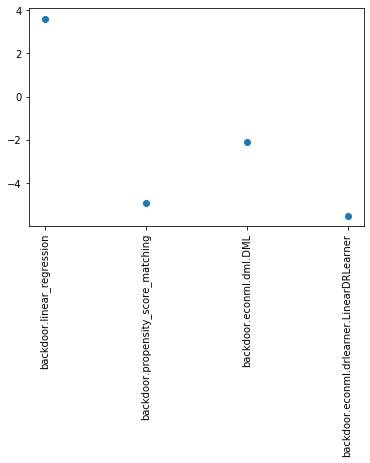

backdoor.linear_regression: 3.620862678166359
backdoor.propensity_score_matching: -4.937260676865596
backdoor.econml.dml.DML: -2.117627906002552
backdoor.econml.drlearner.LinearDRLearner: -5.525244017636955


In [12]:
plot_deviations(estimator_list, deviation_list)
for i in range(len(estimator_list)):
    print(estimator_list[i] +": "+ str(deviation_list[i]))

In [13]:
{k: v for k, v in sorted(zip(estimator_list, deviation_list), key=lambda item: item[1], reverse = True)}


{'backdoor.linear_regression': 3.620862678166359,
 'backdoor.econml.dml.DML': -2.117627906002552,
 'backdoor.propensity_score_matching': -4.937260676865596,
 'backdoor.econml.drlearner.LinearDRLearner': -5.525244017636955}

### Ranking based on New Effect (Refutatation results) 

The ranking based on absolute value of deviations is :
1. Propensity Score Matching 
2. Linear DR Learner 
3. DML CATE Estimator 
4. Linear Regression

Clearly, the observed unmodelled confounding error is not able to match the ranking based on the Original Estimate. It is not even able to tell that the clear winner amongst the methods according to the true value is DML CATE Estimator 

## Unobserved confounding error

For each estimator, we now simulate unobserved confounders and check its effect using dummy outcome refuter to check the unobserved confounding error for each estimator. That is, we run the refutation test for each estimator not only on the observed confounder, but also on an unobserved confounder that we simulate using the AddUnobservedCommonCause class and analyse whether there is a strong confounder that is unobserved (missing) and needs to be accounted for. 

In [14]:
unobserved_confounding_error = Experiment(
    experiment_name='Test',
    experiment_id='2',
    num_experiments=10, # 10
    sample_sizes=sample_size,
    dgps=dgp_list,
    estimators=estimator_tuples,
    refuters=refuter_tuples,
    simulate_unobserved_confounding = True
)

# Run the experiment
res = pd.read_csv(unobserved_confounding_error.experiment())

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['t1'] on outcome ['y']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2




Running Experiment: Test_2


Running Experiment Number: 0


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.07433219],
       [  1.86437677],
       [  0.34325289],
       [  2.01935684],
       [  0.45205222],
       [ -0.74578421]]), 'confounder=>outcome': array([[1.00942410e+02],
       [7.87337996e-01],
       [3.39211381e-01],
       [8.38616458e-02],
       [8.19154334e-01],
       [1.62784153e+00]]), 'effect_modifier=>outcome': array([[0.71160853],
       [0.50626448]]), 'treatment=>outcome': array([[-0.31087694]])}
        bias: {'confounder=>treatment': array([-0.14233977]), 'confounder=>outcome': array([-0.09609283])}
        seed: None
        treatment_is_binary: True
        percentile: 0.9
  

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


INFO:dowhy.causal_refuters.add_unobserved_common_cause:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [55.18256689739501, 60.440261436611856, 54.416170375058265, 51.36127883399426, 54.741456564062894]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x0000022874D86CC8>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0       886.024408
1      3109.616877
2       974.087671
3      1618.600702
4     -2277.563419
          ...     
995     -56.090336
996    1188.575252
997    4898.225601
998    1055.900673
999    -805.332487
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228749DF448>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0       885.819456
1      3109.530572
2       972.380917
3      1620.853827
4     -2273.555551
          ...     
995     -57.899565
996    1189.265433
997    4900.485712
998    1054.399508
999    -807.553757
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.cau

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x0000022874D86D88>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0       887.062820
1      3109.631616
2       973.156898
3      1617.869072
4     -2277.359864
          ...     
995     -59.668237
996    1190.204751
997    4897.413616
998    1056.330840
999    -805.672653
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:d

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228749E0B08>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0       887.429624
1      3110.808626
2       974.068001
3      1616.472514
4     -2276.342354
          ...     
995     -57.856891
996    1190.377244
997    4898.583883
998    1054.970374
999    -806.018161
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228721681C8>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0       885.552323
1      3110.401784
2       973.953302
3      1619.530484
4     -2275.533373
          ...     
995     -57.622134
996    1188.577183
997    4896.785640
998    1055.338382
999    -806.696522
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [14.220660228271054, 8.070147178164813, 14.041167765838651, 11.289685382085215, 15.830851959854382]
p_value [0.007926338127170671, 0.32093138655064546, 0.13285687634393362, 0.18875396163043395, 0.034242978646891006]
true value -2.0688989774993507


Running Experiment Number: 1


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.210826  ],
       [ -0.89663495],
       [  0.85503159],
       [ -0.71551311],
       [ -1.38258733],
       [ -0.25516296]]), 'confounder=>outcome': array([[99.79143779],
       [ 0.49938667],
       [-0.23966983],
       [ 0.5316778 ],
       [-0.6391753 ],
       [-0.69775343]]), 'effect_modi

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


INFO:dowhy.causal_refuters.add_unobserved_common_cause:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [64.1680008526193, 59.171666776831174, 62.745450425951915, 56.219168167110446, 64.50254783529056]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0       885.552323
1      3110.401784
2       973.953302
3      1619.530484
4     -2275.533373
          ...     
995     -57.622134
996    1188.577183
997    4896.785640
998    1055.338382
999    -806.696522
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228746E9C08>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0       737.393707
1       271.264459
2     -1246.741686
3        29.540707
4      -177.359985
          ...     
995     212.353227
996   -2025.003866
997    1204.455844
998    -866.059365
999    -676.895518
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228746CAF08>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0       735.419140
1       271.419642
2     -1244.724379
3        31.150474
4      -177.454205
          ...     
995     210.840693
996   -2025.038422
997    1205.896036
998    -866.276887
999    -676.868222
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.cau

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228749DFB48>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0       734.216764
1       271.607087
2     -1246.465617
3        31.315663
4      -177.947434
          ...     
995     211.799235
996   -2024.705939
997    1205.631730
998    -867.250015
999    -676.991666
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:d

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x0000022873654308>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0       735.733728
1       271.499531
2     -1245.399775
3        30.574893
4      -177.798216
          ...     
995     212.399764
996   -2025.019737
997    1205.694633
998    -864.107307
999    -677.118398
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x0000022873357288>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0       735.081342
1       271.427726
2     -1247.009398
3        29.219769
4      -175.638350
          ...     
995     209.010947
996   -2025.021447
997    1206.626058
998    -866.283008
999    -676.019610
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [13.297121110461187, 5.9715932573633195, 1.7390608661823144, -2.2087988697669987, 6.075684457494733]
p_value [0.03544844390569237, 0.3233187803450168, 0.4490771601742228, 0.2698774449456951, 0.16513974638130757]
true value -1.9702282167998624


Running Experiment Number: 2


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.92086656],
       [  0.46990834],
       [  0.76197544],
       [  0.40273447],
       [  1.21772308],
       [ -1.23828636]]), 'confounder=>outcome': array([[99.85474919],
       [ 0.82085291],
       [-1.57865312],
       [ 1.40832346],
       [ 0.54192967],
       [ 0.3137315 ]]), 'effect_modifier

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


INFO:dowhy.causal_refuters.add_unobserved_common_cause:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [55.44427818834717, 52.299321852720006, 54.116207797546664, 46.726262748355076, 56.099571755893095]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0       735.081342
1       271.427726
2     -1247.009398
3        29.219769
4      -175.638350
          ...     
995     209.010947
996   -2025.021447
997    1206.626058
998    -866.283008
999    -676.019610
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228749E0F08>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0      1335.715732
1      1845.793022
2       461.964981
3       148.383289
4      1682.419894
          ...     
995   -1774.949706
996    2845.011063
997    -468.288458
998    -505.790037
999    2300.006517
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228748F63C8>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0      1335.623793
1      1844.612020
2       460.157862
3       148.520045
4      1680.081401
          ...     
995   -1777.716857
996    2844.120425
997    -468.687541
998    -504.232070
999    2299.791475
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.cau

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x0000022871D98BC8>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0      1337.796580
1      1844.456423
2       463.052456
3       150.581955
4      1681.972214
          ...     
995   -1776.558146
996    2844.439196
997    -467.663413
998    -505.330437
999    2300.971127
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:d

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228746B3308>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0      1336.407962
1      1844.453364
2       461.785808
3       148.347539
4      1683.280025
          ...     
995   -1776.607795
996    2844.176676
997    -467.919556
998    -505.586445
999    2300.760986
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x0000022873461BC8>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0      1336.043197
1      1844.404948
2       461.691145
3       150.325945
4      1682.057640
          ...     
995   -1774.900544
996    2845.430911
997    -468.203187
998    -505.411029
999    2300.929637
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-1.7677459745633068, 8.604887293589892, 17.377429865749768, -0.18892142715188598, 12.522762600381101]
p_value [0.42137045628532455, 0.2981195998193763, 0.038273744349217764, 0.4721417672628778, 0.0019441993047456254]
true value 1.6003551511669238


Running Experiment Number: 3


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[99.52263818],
       [ 1.77193872],
       [-1.40007433],
       [-1.04970173],
       [ 0.41682674],
       [ 0.17731216]]), 'confounder=>outcome': array([[100.70560447],
       [  0.59105446],
       [  1.49935017],
       [  1.10332651],
       [ -0.60926048],
       [ -0.9424016 ]]), 'effect_mod

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


INFO:dowhy.causal_refuters.add_unobserved_common_cause:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [58.104749230307746, 57.55629692706383, 58.227224282898995, 61.38670292745906, 57.82495927387495]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0      1336.043197
1      1844.404948
2       461.691145
3       150.325945
4      1682.057640
          ...     
995   -1774.900544
996    2845.430911
997    -468.203187
998    -505.411029
999    2300.929637
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228732D94C8>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -1145.201998
1     -1286.989080
2     -2581.190808
3      -204.031248
4      -204.488006
          ...     
995     -91.393166
996    -334.676223
997    1967.066366
998    1986.178959
999     144.834026
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x0000022873388288>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -1142.730734
1     -1285.252551
2     -2581.581565
3      -204.651405
4      -206.386987
          ...     
995     -91.580833
996    -333.904813
997    1963.959397
998    1984.571129
999     145.833346
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.cau

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x0000022873386CC8>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -1142.523696
1     -1285.334141
2     -2582.958131
3      -205.902578
4      -204.732566
          ...     
995     -90.369330
996    -333.201451
997    1966.530423
998    1987.380363
999     146.739287
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:d

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228732D94C8>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -1143.317191
1     -1286.921880
2     -2583.276144
3      -204.936553
4      -205.900104
          ...     
995     -89.474081
996    -335.455772
997    1965.549484
998    1985.702191
999     146.922375
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228734FF088>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -1142.436302
1     -1284.755796
2     -2582.647500
3      -205.037313
4      -205.350348
          ...     
995     -90.781008
996    -335.071387
997    1967.534770
998    1985.100981
999     145.949522
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [9.586451403427727, 3.6489125211141236, 7.390598157190698, -0.9745538659814779, 9.9362536463517]
p_value [0.14256742384924131, 0.2520179025739736, 0.23659746688157213, 0.36299134490283547, 1.1210592238043359e-05]
true value -0.2561831959742903


Running Experiment Number: 4


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[99.71964107],
       [ 1.00490758],
       [ 2.02296654],
       [ 0.55340012],
       [ 0.88112747],
       [ 1.21420712]]), 'confounder=>outcome': array([[ 9.88261500e+01],
       [ 1.95499617e-01],
       [ 1.27295128e+00],
       [-2.02748018e-02],
       [-1.45971626e-01],
       [ 3.76948200e-01]]

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


INFO:dowhy.causal_refuters.add_unobserved_common_cause:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [74.59460095479311, 66.68360996413962, 74.49836130745216, 69.62846745612772, 74.60146904578933]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -1142.436302
1     -1284.755796
2     -2582.647500
3      -205.037313
4      -205.350348
          ...     
995     -90.781008
996    -335.071387
997    1967.534770
998    1985.100981
999     145.949522
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228734DCE88>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -2076.816975
1       -20.181858
2     -1003.472942
3      -291.037538
4       728.182789
          ...     
995   -1567.178479
996   -1115.066377
997    1335.885473
998    -246.916243
999     204.671005
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x0000022874D86D88>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -2078.868450
1       -20.774723
2     -1001.245391
3      -291.947832
4       728.803280
          ...     
995   -1567.814609
996   -1115.985884
997    1336.878187
998    -244.463289
999     205.523236
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.cau

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x0000022873388288>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -2077.577696
1       -20.807257
2     -1003.030557
3      -293.676578
4       729.853539
          ...     
995   -1567.740167
996   -1115.915696
997    1337.103538
998    -244.907950
999     204.934033
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:d

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x0000022874A64B08>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -2078.995253
1       -22.571073
2     -1003.969491
3      -292.227383
4       730.028600
          ...     
995   -1567.296975
996   -1116.786151
997    1337.246672
998    -245.342403
999     204.634466
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228734614C8>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -2079.003991
1       -21.540103
2     -1002.389086
3      -293.034232
4       728.244162
          ...     
995   -1567.062756
996   -1115.422597
997    1336.410172
998    -244.003519
999     204.028876
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [10.100552958458039, 13.002102187260695, -3.969169986024537, 2.389207680179451, 8.81321813164233]
p_value [0.07903853422679102, 0.11442993038781496, 0.1544888691141948, 0.4256774516047206, 0.16611718638956285]
true value -0.609681163399245


Running Experiment Number: 5


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[101.1620353 ],
       [  0.20096202],
       [  0.83312038],
       [ -0.19936883],
       [ -0.61294269],
       [ -0.81896653]]), 'confounder=>outcome': array([[100.76472037],
       [  0.93212604],
       [  0.25691303],
       [  0.63804508],
       [  0.23372473],
       [  1.58478531]]), 'effect_modif

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


INFO:dowhy.causal_refuters.add_unobserved_common_cause:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [48.88576929967731, 56.924023035852215, 49.93153300619638, 52.010248599486964, 49.309876667708245]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -2079.003991
1       -21.540103
2     -1002.389086
3      -293.034232
4       728.244162
          ...     
995   -1567.062756
996   -1115.422597
997    1336.410172
998    -244.003519
999     204.028876
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228733BAF08>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0      1502.816946
1      -551.377945
2      -136.573682
3      2188.557532
4      1497.092491
          ...     
995    6361.066313
996   -1459.430392
997   -1006.600548
998   -1592.148854
999   -2685.033336
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x0000022872180D88>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0      1503.233412
1      -550.074237
2      -135.636687
3      2187.790174
4      1495.653390
          ...     
995    6359.380657
996   -1458.048093
997   -1009.629624
998   -1592.352348
999   -2684.414864
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.cau

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x000002287332E088>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0      1502.214181
1      -548.960586
2      -135.853172
3      2187.607579
4      1496.854867
          ...     
995    6360.911542
996   -1459.184021
997   -1008.657138
998   -1591.728295
999   -2682.052703
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:d

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x000002287473A508>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0      1502.920445
1      -550.224272
2      -134.911219
3      2187.390927
4      1496.635592
          ...     
995    6361.639822
996   -1459.933600
997   -1010.064012
998   -1592.244085
999   -2684.234011
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x000002287345DC88>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0      1501.336665
1      -551.646082
2      -134.276647
3      2188.068102
4      1495.771368
          ...     
995    6361.401766
996   -1459.525414
997   -1010.532823
998   -1591.913539
999   -2681.742967
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [4.988056602945219, 4.243248196636616, 6.456526612001279, 0.6784927372876325, -5.863483320677722]
p_value [0.2963145781831768, 0.3446068391513608, 0.0732805214180086, 0.4940996178262118, 0.17261771740306098]
true value -1.57571472016098


Running Experiment Number: 6


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[101.09504395],
       [ -0.21093248],
       [ -0.24433887],
       [ -0.70250674],
       [  0.74315403],
       [ -0.41688439]]), 'confounder=>outcome': array([[99.85120702],
       [-0.11089562],
       [ 0.76670479],
       [-0.40380096],
       [-0.37040649],
       [-1.06439861]]), 'effect_modifier=>outc

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


INFO:dowhy.causal_refuters.add_unobserved_common_cause:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [63.53110986682401, 61.931847939314686, 63.74014146731949, 62.08303070210125, 63.57278140019137]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0      1501.336665
1      -551.646082
2      -134.276647
3      2188.068102
4      1495.771368
          ...     
995    6361.401766
996   -1459.525414
997   -1010.532823
998   -1591.913539
999   -2681.742967
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228747E7048>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -1863.394952
1     -2367.731755
2      4576.571533
3     -1384.214923
4     -2229.684845
          ...     
995   -1854.612540
996   -1421.511508
997   -1945.659071
998     357.077220
999   -2006.744076
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228733DFA48>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -1863.262550
1     -2367.873772
2      4575.880184
3     -1382.823241
4     -2230.837510
          ...     
995   -1852.537570
996   -1425.184530
997   -1945.265044
998     356.219603
999   -2006.791323
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.cau

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x000002287335F248>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -1863.584598
1     -2365.840255
2      4578.429619
3     -1382.917518
4     -2230.304318
          ...     
995   -1852.357092
996   -1423.199507
997   -1945.076668
998     354.894337
999   -2008.126730
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:d

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x000002287361E908>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -1864.159708
1     -2367.141274
2      4578.441947
3     -1383.812169
4     -2230.189382
          ...     
995   -1852.778074
996   -1423.184286
997   -1946.114694
998     357.445803
999   -2006.746301
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228734C9508>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -1863.802856
1     -2366.480278
2      4576.280095
3     -1382.989955
4     -2231.599923
          ...     
995   -1852.808531
996   -1425.744907
997   -1944.293190
998     355.202186
999   -2007.014647
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [8.00478576057186, 9.056765595264668, 12.736520869376582, 8.06222164142277, 4.915760196002481]
p_value [0.06457354680892857, 0.1308871899547559, 0.08975338367769542, 0.21174377930539395, 0.2689411461720407]
true value -0.2834943286208714


Running Experiment Number: 7


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.4617172 ],
       [ -0.3511453 ],
       [  1.68591761],
       [  0.72115749],
       [ -1.04550055],
       [  1.62626918]]), 'confounder=>outcome': array([[ 1.00299028e+02],
       [-8.24910198e-01],
       [-1.23584859e+00],
       [ 1.57282627e+00],
       [ 1.65191493e+00],
       [-5.69747788e-02]]

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


INFO:dowhy.causal_refuters.add_unobserved_common_cause:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [62.025216801367705, 61.03896835065978, 62.170898327673726, 48.81600969497826, 61.87093458889445]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -1863.802856
1     -2366.480278
2      4576.280095
3     -1382.989955
4     -2231.599923
          ...     
995   -1852.808531
996   -1425.744907
997   -1944.293190
998     355.202186
999   -2007.014647
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x0000022874D5EC48>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -2211.251624
1     -3418.202460
2     -1464.773087
3      1097.580378
4      2600.955072
          ...     
995    1167.293078
996   -1531.772873
997     444.188242
998   -2100.814026
999    1114.936148
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228732F7748>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -2210.145388
1     -3419.934997
2     -1464.192929
3      1097.448427
4      2600.339183
          ...     
995    1166.885082
996   -1532.956471
997     443.691996
998   -2100.519337
999    1116.705053
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.cau

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228735F9888>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -2210.016615
1     -3418.511114
2     -1464.984834
3      1096.719967
4      2601.190324
          ...     
995    1165.913331
996   -1530.211587
997     443.893923
998   -2100.070521
999    1113.922397
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:d

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x0000022872109D08>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -2211.057871
1     -3418.720233
2     -1466.598597
3      1097.453336
4      2601.374979
          ...     
995    1168.954920
996   -1533.397168
997     444.971123
998   -2101.333788
999    1115.790399
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x000002287215DE88>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -2210.333385
1     -3418.401141
2     -1463.480937
3      1098.510332
4      2599.024316
          ...     
995    1168.286543
996   -1532.835618
997     445.731650
998   -2098.824264
999    1114.938970
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [3.1924236151443353, 7.158130666308523, -0.1173293981450465, 2.920494776320211, -5.036165864849269]
p_value [0.3965386931871492, 0.3029754262839074, 0.4687801563617503, 0.3845085932707414, 0.33248050573884036]
true value -0.36542613230371634


Running Experiment Number: 8


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 1.00199398e+02],
       [-1.02117949e+00],
       [-4.97840186e-01],
       [ 3.71416858e-01],
       [-7.90720786e-01],
       [-7.70909067e-02]]), 'confounder=>outcome': array([[98.1255774 ],
       [-1.16050815],
       [ 2.84982643],
       [ 0.55545746],
       [-0.36334986],
       [ 1.12114618]]),

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


INFO:dowhy.causal_refuters.add_unobserved_common_cause:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [62.743853376361386, 67.15881975141896, 64.60102822220878, 58.36423392523547, 62.507224760332065]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -2210.333385
1     -3418.401141
2     -1463.480937
3      1098.510332
4      2599.024316
          ...     
995    1168.286543
996   -1532.835618
997     445.731650
998   -2098.824264
999    1114.938970
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x000002287472AF08>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0      1576.467446
1       899.612305
2      3396.643947
3      -207.705229
4      2527.613489
          ...     
995     355.071899
996    -257.757240
997     771.853222
998    1750.068856
999     817.328049
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228749B1C48>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0      1574.491505
1       899.287505
2      3398.298772
3      -206.092775
4      2529.311891
          ...     
995     354.699720
996    -258.647144
997     772.235431
998    1751.050074
999     816.578717
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.cau

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x0000022874641448>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0      1576.797662
1       898.257952
2      3398.144771
3      -208.155619
4      2528.998805
          ...     
995     355.134221
996    -258.161810
997     771.827148
998    1752.125605
999     816.894827
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:d

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x000002287217E048>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0      1576.512393
1       899.354282
2      3396.932486
3      -206.295283
4      2528.584210
          ...     
995     356.084812
996    -260.140789
997     770.998520
998    1748.452592
999     817.901841
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228735DC908>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0      1575.601305
1       898.664364
2      3397.454502
3      -206.037929
4      2529.362455
          ...     
995     357.553907
996    -260.710003
997     771.103588
998    1748.237675
999     815.861052
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [4.3884992174885, 18.349889887028873, 17.20889390325838, -0.05929473907406228, 8.915155764534438]
p_value [0.24795793012521222, 0.02915101350959265, 0.03137518880089054, 0.45108253609235094, 0.06305341016184739]
true value -1.425587779646994


Running Experiment Number: 9


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[101.02646832],
       [  1.40124536],
       [ -0.35387936],
       [ -0.29347704],
       [  0.88260002],
       [  0.60329882]]), 'confounder=>outcome': array([[100.99981109],
       [ -1.45588402],
       [  0.78299423],
       [ -0.44974769],
       [  1.97394442],
       [ -1.30395767]]), 'effect_mod

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~t1+w3+w2+x1+x2 | x1,x2


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.drlearner.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.drlearner.LinearDRLearner'}


INFO:dowhy.causal_refuters.add_unobserved_common_cause:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [57.52625611273547, 55.02584292009278, 56.945490337749604, 52.757234195410085, 57.21603277112778]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0      1575.601305
1       898.664364
2      3397.454502
3      -206.037929
4      2529.362455
          ...     
995     357.553907
996    -260.710003
997     771.103588
998    1748.237675
999     815.861052
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x000002287477EF48>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -1103.713173
1     -1446.668879
2      1700.698124
3      2175.403636
4      -360.436432
          ...     
995    3112.996869
996    1475.820174
997    1093.827376
998    3302.777290
999    3300.649145
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1*x2
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+t1*x1+t1

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x00000228733B54C8>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -1103.734669
1     -1447.218977
2      1702.972466
3      2175.133603
4      -358.679528
          ...     
995    3116.049819
996    1476.170576
997    1092.710894
998    3303.265692
999    3300.187491
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.cau

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x0000022874A0C388>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -1102.900166
1     -1445.993162
2      1702.739541
3      2177.150775
4      -359.309341
          ...     
995    3116.139223
996    1476.946259
997    1093.986252
998    3302.669507
999    3301.692235
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:d

printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x000002287493EC48>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -1103.719164
1     -1447.762458
2      1703.702931
3      2177.127763
4      -358.063007
          ...     
995    3113.864080
996    1475.986492
997    1093.179585
998    3302.361864
999    3301.531649
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x0000022874805CC8>


INFO:dowhy.causal_refuter:All variables required: Running bootstrap adding noise to confounders, instrumental variables and effect modifiers.
INFO:dowhy.causal_refuters.dummy_outcome_refuter:Refutation over 5 simulated datasets
INFO:dowhy.causal_refuters.dummy_outcome_refuter:The transformation passed: [('random_forest', {'n_estimators': 100, 'max_depth': 6})]


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x0000022829325828>, 'unobserved_confounder_values': 0     -1102.470974
1     -1445.850540
2      1702.217484
3      2177.458750
4      -359.500734
          ...     
995    3115.122238
996    1475.965777
997    1095.448733
998    3300.929032
999    3302.086491
Length: 1000, dtype: float64}


INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: dummy_outcome~t1+w3+w2+x1+x2 | x1,x2


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [8.566197941906305, 6.82196921229701, 6.633351486118133, 5.212227976885458, 5.987062615324367]
p_value [0.09516082997302816, 0.2548250681283013, 0.18386472664419434, 0.1593351158800091, 0.17584379893087243]
true value -0.0947549138445049


Completed all experiments. Saving the data...
Data has been saved in  results/Test_2_2021-01-27_data.csv


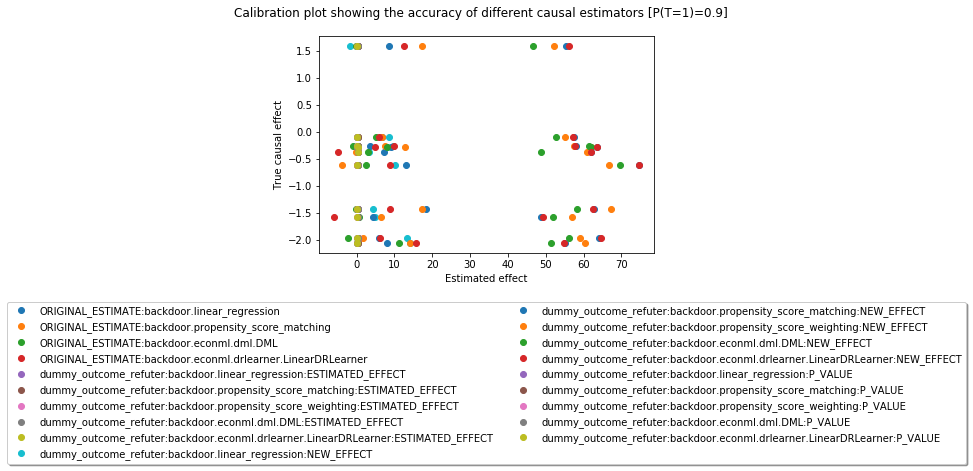

Printing MAE of various estimates: 
ORIGINAL_ESTIMATE:backdoor.econml.drlearner.LinearDRLearner 60.92964689402477
ORIGINAL_ESTIMATE:backdoor.linear_regression 60.92560158575111
ORIGINAL_ESTIMATE:backdoor.propensity_score_matching 60.528027323178776
ORIGINAL_ESTIMATE:backdoor.econml.dml.DML 56.640225152734146
dummy_outcome_refuter:backdoor.propensity_score_weighting:NEW_EFFECT 9.32656420638797
dummy_outcome_refuter:backdoor.propensity_score_matching:NEW_EFFECT 9.197726027211143
dummy_outcome_refuter:backdoor.linear_regression:NEW_EFFECT 8.836281939265426
dummy_outcome_refuter:backdoor.econml.drlearner.LinearDRLearner:NEW_EFFECT 8.706373112926602
dummy_outcome_refuter:backdoor.econml.dml.DML:NEW_EFFECT 3.966281137187547
dummy_outcome_refuter:backdoor.linear_regression:ESTIMATED_EFFECT 1.4250324579416742
dummy_outcome_refuter:backdoor.propensity_score_matching:ESTIMATED_EFFECT 1.4250324579416742
dummy_outcome_refuter:backdoor.propensity_score_weighting:ESTIMATED_EFFECT 1.4250324579416742


In [15]:
##This plot shows the Mean Absolute Error of the Orginal Estimate from the true value and of the New Effect from 
#the expected value for each estimator.
plot_MAEs(res)

### Ranking based on Original Estimate

The Original Estimate is calculated in the presence of the True Value (that is, the ground truth). However in many real life datasets, the ground truth may not be known. Hence, we want the ranking produced by our refutation tests to be in coherence with that obtained from the Original Estimates. According to the Original Estimate values, the ranking of the estimators should be as follows (the method with the least MAE should get the best rank):
1. DMLCateEstimator 
2. Propensity Score Matching 
3. LinearRegression 
4. LinearDRLearner 

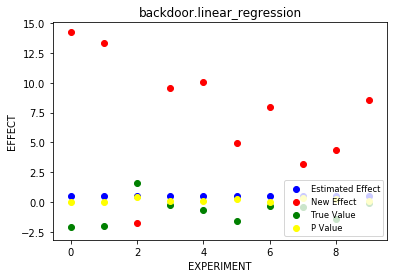

74.57700286411092


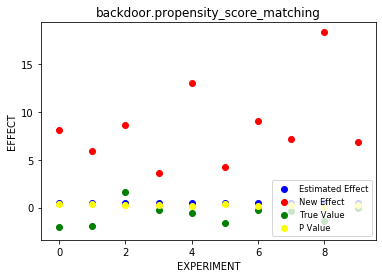

84.92764599502854


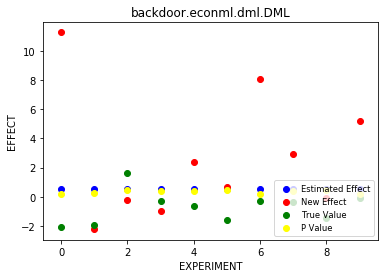

27.120761292206314


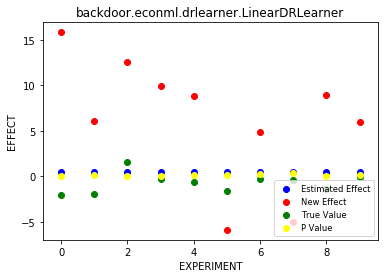

62.09710018605855


<Figure size 432x288 with 0 Axes>

In [16]:
#This plot shows the deviation of the original estimate, the new effect and the estimated effect from the true value
refuter = 'dummy_outcome_refuter'
deviation_list = []
for estimator in estimator_list:
    plot_estimators_and_refuters(refuter, estimator)
    avg_deviation = ((res[refuter+':'+estimator+':NEW_EFFECT']).sum(axis=0))
    print(avg_deviation)
    deviation_list.append(avg_deviation)

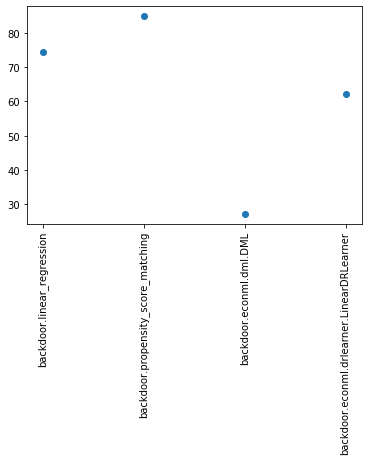

backdoor.linear_regression: 74.57700286411092
backdoor.propensity_score_matching: 84.92764599502854
backdoor.econml.dml.DML: 27.120761292206314
backdoor.econml.drlearner.LinearDRLearner: 62.09710018605855


In [17]:
plot_deviations(estimator_list, deviation_list)
for i in range(len(estimator_list)):
    print(estimator_list[i] +": "+ str(deviation_list[i]))

In [18]:
{k: v for k, v in sorted(zip(estimator_list, deviation_list), key=lambda item: item[1], reverse = True)}

{'backdoor.propensity_score_matching': 84.92764599502854,
 'backdoor.linear_regression': 74.57700286411092,
 'backdoor.econml.drlearner.LinearDRLearner': 62.09710018605855,
 'backdoor.econml.dml.DML': 27.120761292206314}

### Ranking based on New Effect (Refutatation results) 

The ranking based on absolute value of deviations is :
1. DML
2. Propensity Score Matching 
3. Linear Regression
4. Linear DR Learner 

#### We can see that this ranking is exactly the same as the one based on Original Estimate. Thus ranking based on the unobserved confounding error solves the problem and gives us a correct ranking amongst methods